# CIFAR10 Mosaic

Génération d'une image composée d'une mosaïque d'images de la même classe à partir d'une image sélectionné au hasard dans l'ensemble d'entraînement de la bibliothèque d'images [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

1. Réduction de chaque image de la classe à un vecteur (r,g,b) pour avoir un ensemble de tuiles. Chaque tuile est associée à une image de la classe choisie
2. Choix d'une image au hasard
3. Minimisation de la distance L2 entre chaque point de l'image et l'ensemble des tuiles de la classe choisie. Et on remplace chaque point par le numéro de la tuile en question dans l'ensemble d'entraînement.
4. Création d'une nouvelle image à partir des tuiles choisies

In [1]:
%matplotlib inline

# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Fonctions utilisées

In [2]:
from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
#import numpy as np
import os
import platform
import PIL.Image
from io import BytesIO
import IPython.display

# Pour le chargement des données

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    #Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr

# Pour l'affichage

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Chargement des données

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = './datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)


## Réduction de chaque image à un vecteur (r,g,b)

Pour chaque image: calcul de la somme des valeurs selon chaque couleur rgb.

In [4]:
X_reduced = np.sum(X_train, axis = (1,2))

In [5]:
print('reduced data shape: ', X_reduced.shape)
X_reduced[0]


reduced data shape:  (50000, 3)


array([144594., 107622.,  65574.])

## Image initiale

Choix d'une image au hasard

In [8]:
idx = random.randrange(X_train.shape[0])
idx

16995

(-0.5, 31.5, 31.5, -0.5)

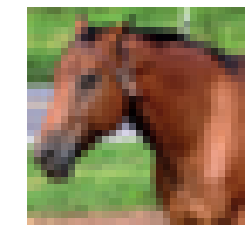

In [9]:
plt.imshow(X_train[idx].astype('uint8'))
plt.axis('off')

Visualisation en taille réelle:

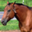

In [10]:
showarray(X_train[idx])

Classe de l'image sélectionnée

In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes[y_train[idx]]

'horse'

## Calcul de la distance L2

Pour chaque pixel de l'image choisie, minimisation de la distance L2 et création d'une matrice correspondante `X_mosaic` avec les indices des images sélectionnées.

In [12]:
X_mosaic = np.zeros((32,32))

# On parcourt l'image pour chaque canal de l'image choisie initialement

for i in range(32):
    for j in range(32):
        pixel = X_train[idx,i,j]
        
        # Comparaison d'un pixel avec les images de la classe choisie
        pixel = pixel * 32 * 32
        
        initialize = True

        for k in range( 1 , X_reduced.shape[0] ):
            if y_train[k] == y_train[idx]:
                if initialize:
                    # Calcul de la distance euclidienne
                    dist_min = np.linalg.norm( pixel - X_reduced[k] )
                    initialize = False

                dist = np.linalg.norm( pixel - X_reduced[k] )
                if  dist < dist_min :
                    dist_min = dist
                    i_pict = k # indice de l'image correspondant à la plus petite distance
        
        X_mosaic[i,j] = i_pict

X_mosaic
                


array([[20681., 47055., 49038., ..., 49038., 32469., 49038.],
       [11935., 11581., 36037., ..., 49038., 36037., 36037.],
       [11935., 11581., 36037., ..., 11581., 11581., 11581.],
       ...,
       [47055., 11581., 11935., ..., 12271., 33592., 27756.],
       [ 2113., 38528.,  1729., ..., 15564., 12271., 10905.],
       [ 7450., 21096., 24568., ..., 30845., 27756.,  5809.]])

## Création et affichage de l'image finale

In [13]:
X_final = np.zeros((32*32, 32*32, 3))

for  c in range(3):
    for i in range(32*32):
        for j in range(32*32):
            # indices de la tuile dans X_mosaic
            i_tile = i//32
            j_tile = j//32
            # Numéro de la tuile correspondante
            tile_number = int(X_mosaic[i_tile,j_tile])
            # Alimentation de X_final avec les éléments de chaque tuile
            X_final[i,j,c] = X_train[ tile_number, i%32, j%32, c ]

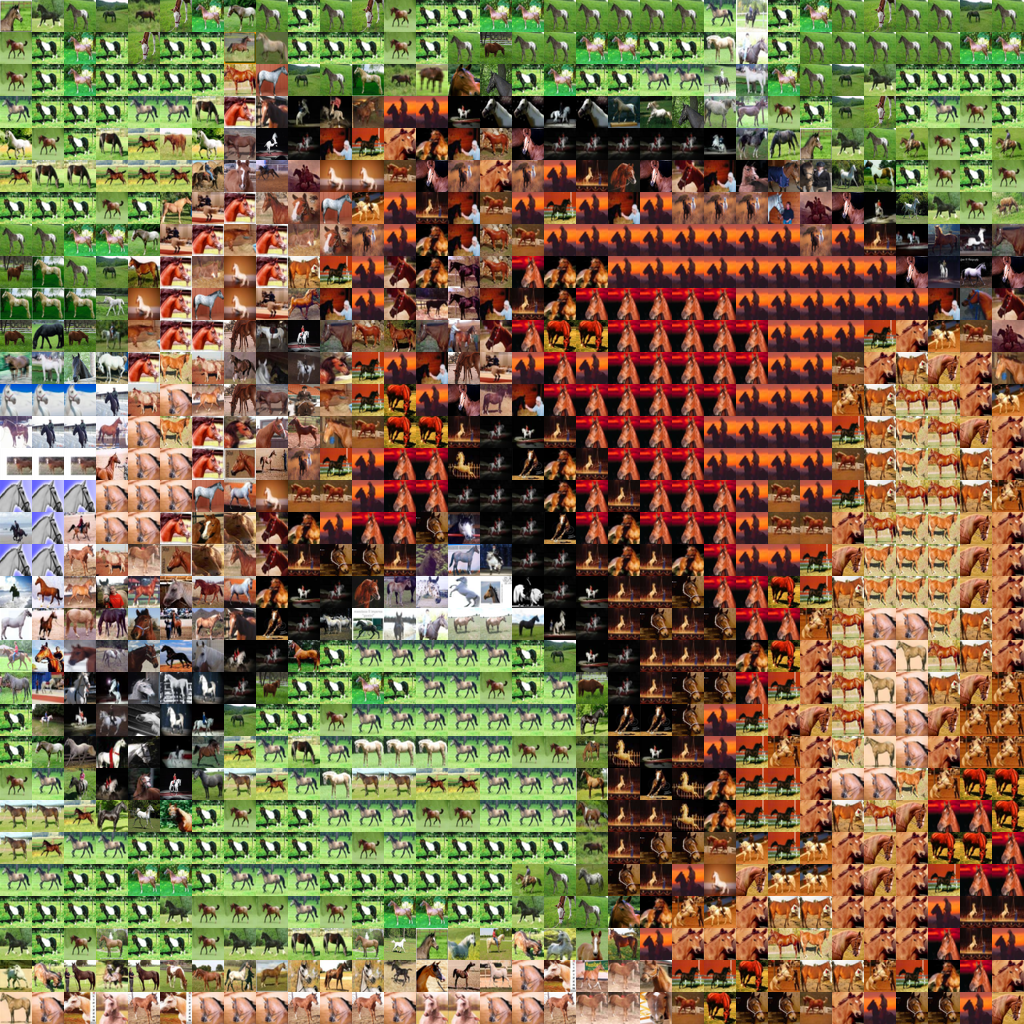

In [14]:
showarray(X_final)